In [530]:
# импорты сторонних библиотек

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle


# импорты модулей текущего проекта
from pickle import dump, load
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [531]:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')

#изначально обрежем значения до 3 знака после запятой при воспроизведении
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#для удобства отображения таблиц
pd.options.display.max_columns = 100

### <a id='toc1_1_1_'></a>[Шаг 2. Предобработка и исследовательский анализ данных](#toc0_)

In [532]:
df_train.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.000,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.000,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.000,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.000,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.000,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.000,110,60,1,1,0,0,0,0


In [533]:
df_test.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.000,130,80,1,1,0,0,1
1,6,19042,2,170,69.000,130,90,1,1,0,0,1
2,7,20432,1,160,70.000,120,75,1,1,0,0,0
3,10,18133,2,185,94.000,130,90,1,1,0,0,1
4,11,16093,2,170,76.000,120,80,1,1,0,0,1


In [534]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [535]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.000,130,80,1,1,0,0,1
1,6,19042,2,170,69.000,130,90,1,1,0,0,1
2,7,20432,1,160,70.000,120,75,1,1,0,0,0
3,10,18133,2,185,94.000,130,90,1,1,0,0,1
4,11,16093,2,170,76.000,120,80,1,1,0,0,1


In [536]:
pd.DataFrame(round(df_train.isna().mean()*100,)).style.background_gradient('coolwarm').format("{:.2f}")

,0
id,0.00
age,0.00
gender,0.00
height,0.00
weight,0.00
ap_hi,0.00
ap_lo,0.00
cholesterol,0.00
gluc,0.00
smoke,0.00


 видим, что пропусков нет


изучим общую информацию о датасете и оценим соответствие типов данных признакам

In [537]:
print ('Проверим датафрейм на дубликаты в обоих датасетах')
print (df_train.duplicated().sum())

Проверим датафрейм на дубликаты в обоих датасетах
0


временно удалим id, чтобы посмотреть имеются ли полные дубликаты, отличающиеся исключительно номером id. По кол-ву таких дубликатов примем решение о том, что с ними необходимо сделать.

In [538]:
df_without_id_train = df_train.drop(columns = ['id'], axis = 1)
print (df_without_id_train.duplicated(keep= 'last').value_counts())

False    69976
True        24
dtype: int64


Итак, по результату исследования видим, что кол-во полных дубликатов 24 штуки. Поскольку кол-во дубликатов небольшое - удалим их.

In [539]:
#df_train = df_without_id_train['id'].drop_duplicates()

In [540]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


по результатам обработки видим, что дубликаты удалены; тип данных полностью соответствует признакам, находящимся в таблице.

МОЖНО ИДТИ ДАЛЬШЕ. Применим описательную статистику для описания датасета. - **Информация предоставленная методом .describe() поможет нам выбрать нужный спсоб заполнения пропущенных значений, при наличии пропусков** Намного интереснее будет ниже обзорно взглянуть на данные через гистограммы - понять какие именно колонки целесообразно изучить подробнее - проработать эти колонки через графики boxplot и уже для них прицельно изучить описательную статистику.

In [541]:
df_train['age'] = df_train['age'] / 365
df_test['age'] = df_test['age'] / 365

In [542]:
df_train['age'] = df_train['age'].astype (float)

df_test['age'] = df_test['age'].astype (float)

In [543]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  float64
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


In [544]:
df_train.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000,70000.000
mean,49972.420,53.339,1.350,164.359,74.206,128.817,96.630,1.367,1.226,0.088,0.054,0.804,0.500
std,28851.302,6.760,0.477,8.210,14.396,154.011,188.473,0.680,0.572,0.283,0.226,0.397,0.500
min,0.000,29.584,1.000,55.000,10.000,-150.000,-70.000,1.000,1.000,0.000,0.000,0.000,0.000
25%,25006.750,48.395,1.000,159.000,65.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.000
50%,50001.500,53.981,1.000,165.000,72.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.000
75%,74889.250,58.430,2.000,170.000,82.000,140.000,90.000,2.000,1.000,0.000,0.000,1.000,1.000
max,99999.000,64.967,2.000,250.000,200.000,16020.000,11000.000,3.000,3.000,1.000,1.000,1.000,1.000


<function matplotlib.pyplot.show(close=None, block=None)>

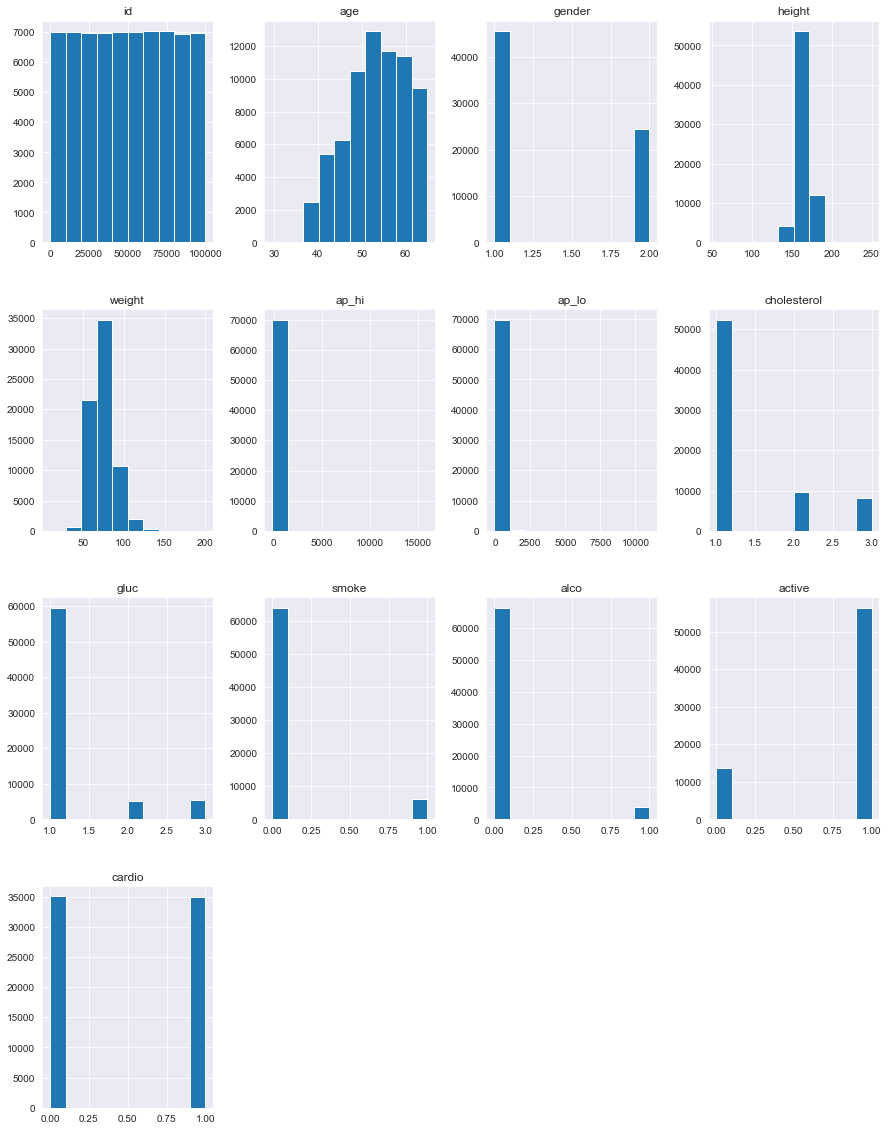

In [545]:
df_train.hist(figsize=(15, 20))
plt.show

In [546]:
df_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [547]:
df_train = df_train.drop('id', axis = 1)

In [548]:
df_test = df_test.drop('id', axis = 1)

изучим некоторые признаки более подробно

count   70000.000
mean       53.339
std         6.760
min        29.584
25%        48.395
50%        53.981
75%        58.430
max        64.967
Name: age, dtype: float64

median  53.98082191780822


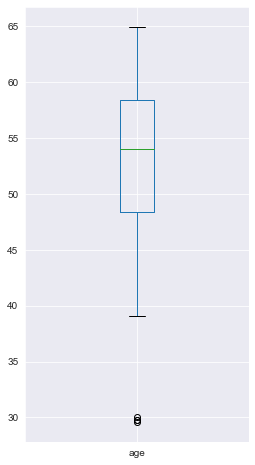

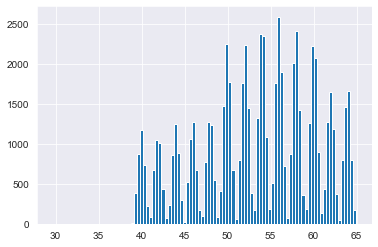

In [549]:
def basis_stat_f(target_column):
    display(df_train[target_column].describe())
    print('median ', df_train[target_column].median())
    df_train.boxplot(column = target_column, figsize = (4,8))
    plt.show()
    df_train[target_column].hist(bins = 100)

basis_stat_f('age')

мы видим выбросы по возрасту 30 лет. С одной стороны, мы понимаем, что риск развития заболеваний ССС в этом возрасте невелик. С другой стороны, опираясь на клинический опыт, приходилось видеть инфаркт миокарда и в 25 лет, но это не частое явление. Пока удалим.

In [550]:
df_train = df_train.loc[df_train['age'] > 33]

удостоверимся, что выбросы удалены

count   69996.000
mean       53.341
std         6.757
min        39.110
25%        48.397
50%        53.981
75%        58.430
max        64.967
Name: age, dtype: float64

median  53.98082191780822


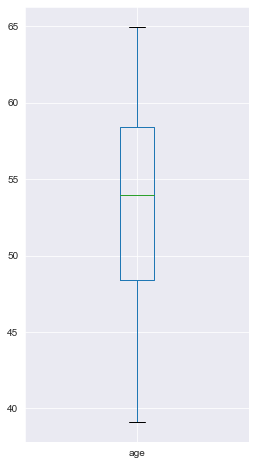

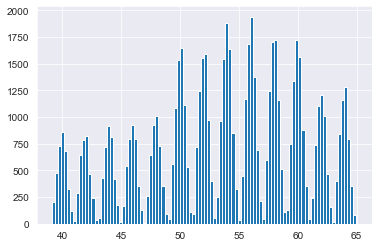

In [551]:
basis_stat_f('age')

все в порядке: идем далее

count   69996.000
mean      164.359
std         8.210
min        55.000
25%       159.000
50%       165.000
75%       170.000
max       250.000
Name: height, dtype: float64

median  165.0


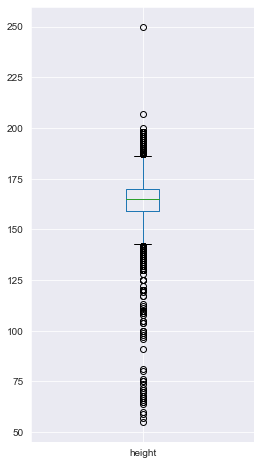

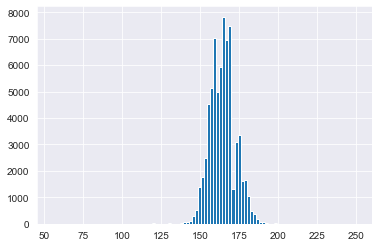

In [552]:
basis_stat_f('height')

на графике boxplot мы наблюдаем большое кол-во выбросов. Удалим все, что меньше 159 и больше 200

In [553]:
df_train = df_train.loc[df_train['height'] > 159]
df_train = df_train.loc[df_train['height'] < 200]

перепроверим корректность процедуры удаления данных

count   51471.000
mean      167.880
std         5.829
min       160.000
25%       164.000
50%       167.000
75%       171.000
max       198.000
Name: height, dtype: float64

median  167.0


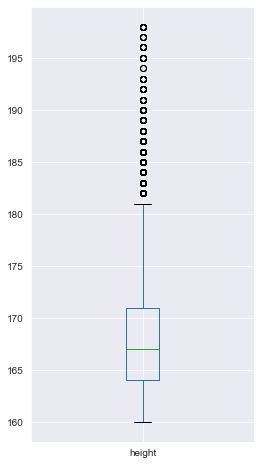

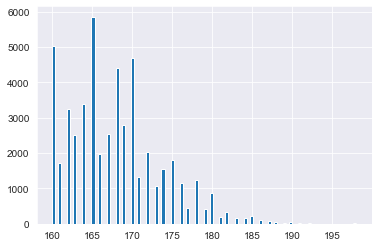

In [554]:
basis_stat_f('height')

изучив гистограмму, приходим к выводу, что все, что выше 185 - единичные наблюдения. Стоит ли их удалять? Отличный вопрос: с одной стороны, это явные аномалии. С другой стороны - возможно, в этих аномалиях и кроются механизмы развития заболеваний ССС, заложенные природой (например, пациенты с дисплазией соединительной ткани высокие и худые - это синдром Марфана). **Принимаем решение: пока не удаляем. Если полученная модель не будет удовлетворять по метрике - попробуем поиграть с отсечением по данному показателю.**

count   51471.000
mean       75.832
std        13.989
min        10.000
25%        66.000
50%        73.000
75%        83.000
max       200.000
Name: weight, dtype: float64

median  73.0


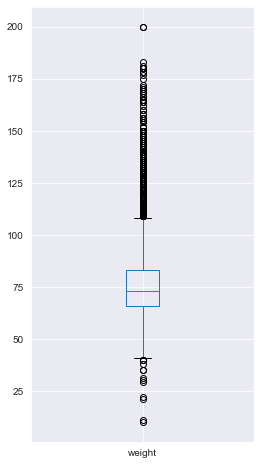

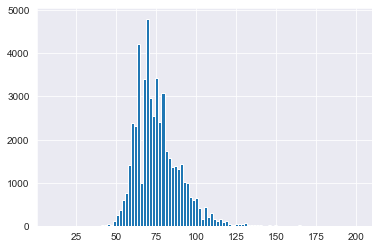

In [555]:
basis_stat_f('weight')

Изучив распределение веса, приходим к следующему выводу: мы предсказываем риск развития заболеваний ССС у взрослых => вес ниже 48 кг - кахексия, явная аномалия. Из курса патологической физиологии нам известно, что малый вес не является предиктором развития заболеваний ССС, в то время, как большой вес является. Принимаем решение: визуально оценивая boxplot, убираем выборосы менее 48 кг, в тоже самое время выбросы вверх, выше 75 перцентиля пока оставляем: будем действовать по принципу, аналогично выше озвученному.

In [556]:
df_train = df_train.loc[df_train['weight'] > 48]

count   51292.000
mean       75.941
std        13.888
min        49.000
25%        66.000
50%        74.000
75%        84.000
max       200.000
Name: weight, dtype: float64

median  74.0


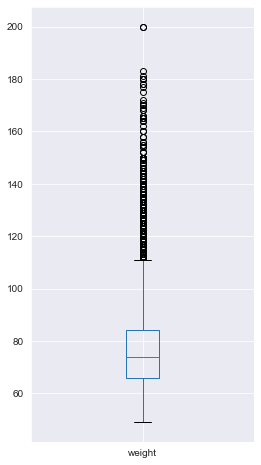

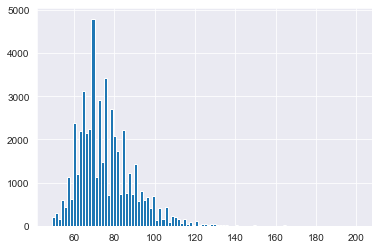

In [557]:
basis_stat_f('weight')

count   51292.000
mean      129.182
std       169.817
min      -150.000
25%       120.000
50%       120.000
75%       140.000
max     16020.000
Name: ap_hi, dtype: float64

median  120.0


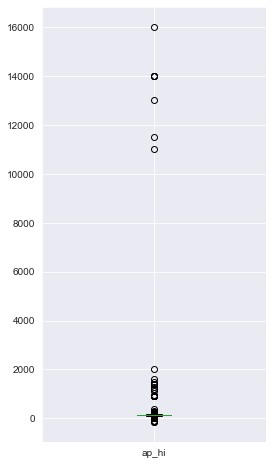

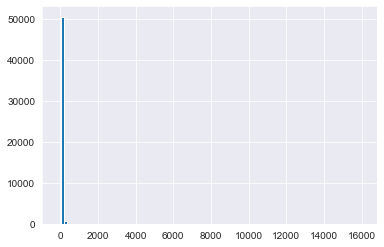

In [558]:
basis_stat_f('ap_hi')

In [559]:
df_train['ap_hi'].value_counts()

 120     21717
 140      6802
 130      6458
 110      5997
 150      3194
         ...  
 1620        1
 96          1
 199         1
-150         1
 2000        1
Name: ap_hi, Length: 144, dtype: int64

In [560]:
df_train['ap_hi'].sort_values()

35040     -150
23988     -140
25240     -120
46627     -120
16021     -115
         ...  
25464    14020
47253    14020
46912    14020
25519    14020
40852    16020
Name: ap_hi, Length: 51292, dtype: int64

In [561]:
df_train['ap_hi'] = df_train['ap_hi'].abs()

count   51292.000
mean      129.211
std       169.795
min         1.000
25%       120.000
50%       120.000
75%       140.000
max     16020.000
Name: ap_hi, dtype: float64

median  120.0


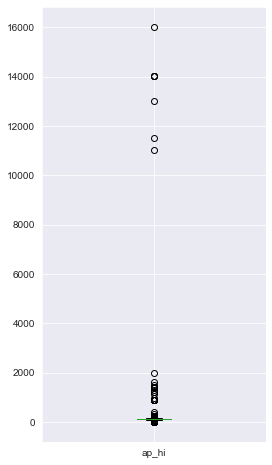

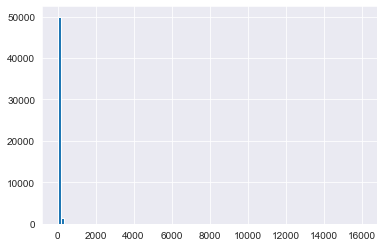

In [562]:
basis_stat_f('ap_hi')


In [563]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51292 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          51292 non-null  float64
 1   gender       51292 non-null  int64  
 2   height       51292 non-null  int64  
 3   weight       51292 non-null  float64
 4   ap_hi        51292 non-null  int64  
 5   ap_lo        51292 non-null  int64  
 6   cholesterol  51292 non-null  int64  
 7   gluc         51292 non-null  int64  
 8   smoke        51292 non-null  int64  
 9   alco         51292 non-null  int64  
 10  active       51292 non-null  int64  
 11  cardio       51292 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 5.1 MB


In [564]:
df_train = df_train.loc[df_train['ap_hi'] < 2500]
#df_train = df_train.loc[df_train['ap_hi'] > 60]

count   51284.000
mean      127.132
std        28.055
min         1.000
25%       120.000
50%       120.000
75%       140.000
max      2000.000
Name: ap_hi, dtype: float64

median  120.0


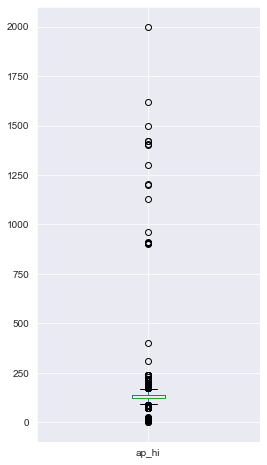

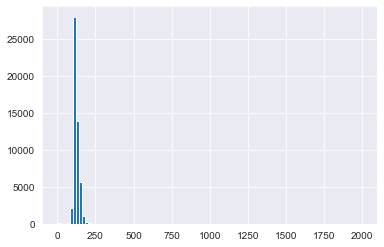

In [565]:
basis_stat_f('ap_hi')

In [566]:
df_train['ap_hi'].sort_values(ascending = False)

69370    2000
28147    1620
13895    1500
8915     1420
43208    1420
         ... 
66315      10
57909      10
5382        7
42334       1
8757        1
Name: ap_hi, Length: 51284, dtype: int64

In [567]:
df_train['ap_hi'].value_counts()

120     21719
140      6803
130      6458
110      5997
150      3195
        ...  
191         1
1500        1
181         1
174         1
2000        1
Name: ap_hi, Length: 134, dtype: int64

In [568]:
def sys(row):
    row = row['ap_hi']
    if row == 1:
        return row * 100
    elif row in range(7, 21):
        return  10
    elif row > 1000:
        return row / 10
    else: return row


In [569]:
df_train['ap_hi'] = df_train.apply(sys, axis = 1)

In [570]:
df_train['ap_hi'].sort_values(ascending = False)

53982   960.000
4817    909.000
31783   907.000
17713   907.000
23867   906.000
          ...  
62719    10.000
45232    10.000
927      10.000
55047    10.000
22670    10.000
Name: ap_hi, Length: 51284, dtype: float64

In [571]:
df_train = df_train.loc[df_train['ap_hi'] < 310]

count   51274.000
mean      126.712
std        17.591
min        10.000
25%       120.000
50%       120.000
75%       140.000
max       309.000
Name: ap_hi, dtype: float64

median  120.0


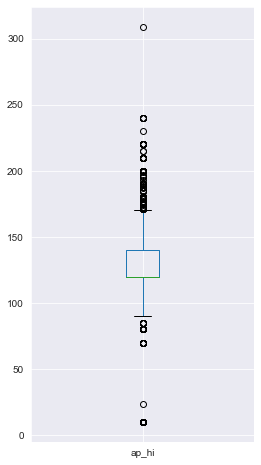

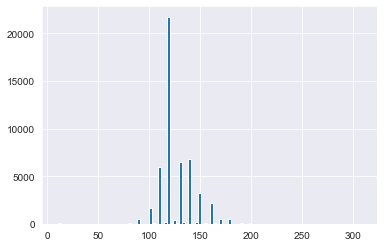

In [572]:
basis_stat_f('ap_hi')

count   51274.000
mean       96.524
std       195.881
min       -70.000
25%        80.000
50%        80.000
75%        90.000
max     11000.000
Name: ap_lo, dtype: float64

median  80.0


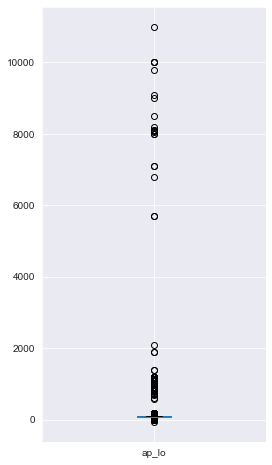

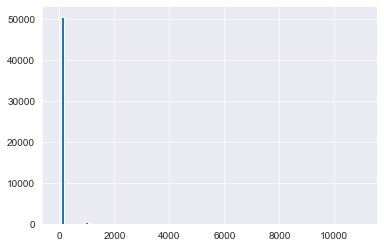

In [573]:
basis_stat_f('ap_lo')

In [574]:
df_train = df_train.loc[df_train['ap_lo'] < 2000]

count   51253.000
mean       93.277
std       105.735
min       -70.000
25%        80.000
50%        80.000
75%        90.000
max      1900.000
Name: ap_lo, dtype: float64

median  80.0


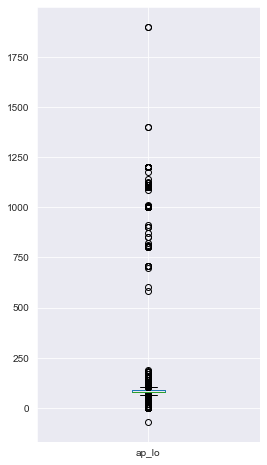

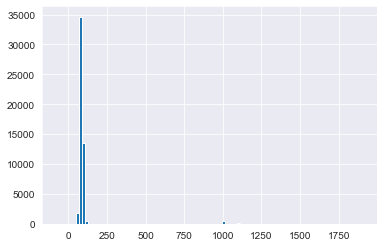

In [575]:
basis_stat_f('ap_lo')

In [576]:
df_train['ap_lo'] = df_train['ap_lo'].abs()

In [577]:
df_train['ap_lo'].sort_values()

56950       0
43922       0
22923       0
45835       0
27686       0
         ... 
58216    1200
66108    1400
49217    1400
29789    1900
55291    1900
Name: ap_lo, Length: 51253, dtype: int64

In [578]:
def dyas(row):
    row = row['ap_lo']
    if row > 150:
        return row / 10

    else: return row

In [579]:
df_train['ap_lo'] = df_train.apply(dyas, axis = 1)

In [580]:
df_train['ap_lo'].sort_values(ascending = False)

55291   190.000
29789   190.000
45637   150.000
44029   150.000
45793   150.000
          ...  
40330     0.000
27686     0.000
56950     0.000
48049     0.000
38370     0.000
Name: ap_lo, Length: 51253, dtype: float64

In [581]:
df_train = df_train.loc[df_train['ap_lo'] > 19]
df_train = df_train.loc[df_train['ap_lo'] < 190]


In [582]:
df_train['ap_lo'].sort_values(ascending = False)


44085   150.000
44029   150.000
37555   150.000
45793   150.000
45637   150.000
          ...  
11820    20.000
40961    20.000
39896    20.000
18958    20.000
20135    20.000
Name: ap_lo, Length: 51215, dtype: float64

In [583]:
df_train_tmp = df_train[['ap_hi', 'ap_lo']]
df_train['ap_hi'], df_train['ap_lo'] = df_train_tmp.max(axis = 1), df_train_tmp.min(axis = 1)

изучим корреляцию числовых признаков

In [584]:
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.392,2,168,62.000,110.000,80.000,1,1,0,0,1,0
2,51.663,1,165,64.000,130.000,70.000,3,1,0,0,0,1
3,48.282,2,169,82.000,150.000,100.000,1,1,0,0,1,1
7,61.874,2,178,95.000,130.000,90.000,3,3,0,0,1,1
9,54.340,1,164,68.000,110.000,60.000,1,1,0,0,0,0


In [585]:
df_train_nk = df_train.drop(columns = ['smoke', 'alco', 'active', 'cardio'])

<AxesSubplot:>

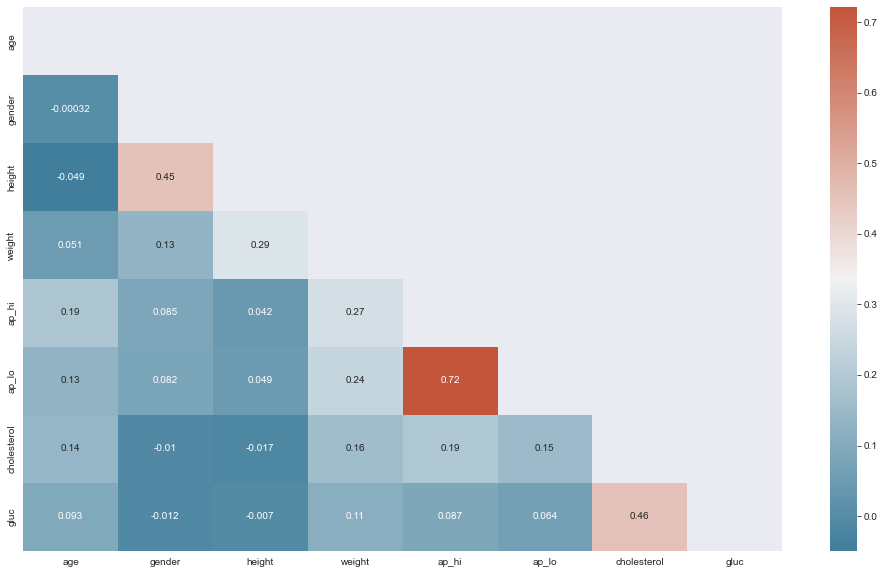

In [586]:
# корреляция между разными значениями
corr = df_train_nk.corr()

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(17, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)


# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

### <a id='toc1_1_1_'></a>[Шаг 3. Создание предиктивной модели ML](#toc0_)

В качестве основной метрики будем использовать метрику AUC-ROC, репрезентативную условиям задачи.


In [587]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51215 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          51215 non-null  float64
 1   gender       51215 non-null  int64  
 2   height       51215 non-null  int64  
 3   weight       51215 non-null  float64
 4   ap_hi        51215 non-null  float64
 5   ap_lo        51215 non-null  float64
 6   cholesterol  51215 non-null  int64  
 7   gluc         51215 non-null  int64  
 8   smoke        51215 non-null  int64  
 9   alco         51215 non-null  int64  
 10  active       51215 non-null  int64  
 11  cardio       51215 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 5.1 MB


разбиваем данные по 3 датафреймам на обучающую и валидационную выборки

In [588]:
df_0_train, df_0_valid = train_test_split(df_train, test_size=0.25, random_state=12345)

 проведем масштабирование признаков, с целью стандартизации

In [589]:
numeric = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [590]:
#pd.options.mode.chained_assignment = None

#scaler = StandardScaler()
#scaler.fit(df_0_train[numeric])

#df_0_train[numeric] = scaler.transform(df_0_train[numeric])
#df_0_valid[numeric] = scaler.transform(df_0_valid[numeric])
#df_test[numeric] = scaler.transform(df_test[numeric])

для обоих выборок, выделим в датасете целевой признак и проверим что получилось

In [591]:
target_train = df_0_train['cardio']
features_train = df_0_train.drop('cardio', axis=1)
target_valid = df_0_valid['cardio']
features_valid = df_0_valid.drop('cardio', axis=1)

In [592]:
target_train.shape

(38411,)

In [593]:
features_train.shape

(38411, 11)

In [594]:
target_valid.shape

(12804,)

In [595]:
features_valid.shape

(12804, 11)

In [596]:
hjk

NameError: name 'hjk' is not defined

подбор гиперпараметров через OPTUNA

In [ ]:
%%time
def objective(trial):
    random_state = 42
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 120),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        "max_features": trial.suggest_int("max_features", 3, 15),
        'bootstrap'  : trial.suggest_categorical('bootstrap', [True, False])
    }
    classifier_obj = RandomForestClassifier(random_state=23, **params)
    result = cross_val_score(classifier_obj, features_train, target_train,n_jobs=-1, cv=3,scoring='roc_auc')
    result = result.mean()
    return result



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 60)
trial = study.best_trial


print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
df =

In [ ]:
df_test.info()

In [ ]:

data = {'age' : [45], 'gender' : [1], 'height' : [150], 'weight' : [120], 'ap_hi' : [180], 'ap_lo' : [120], 'cholesterol' : [2], 'gluc' : [2], 'smoke' : [1], 'alco' : [1], 'active' : [0] }
#features_test = pd.DataFrame(data)


In [ ]:
#features_test

In [ ]:
#features_test[numeric] = scaler.transform(features_test[numeric])

In [597]:
features_test = df_test

In [598]:
model_rfc_nb = RandomForestClassifier(n_estimators=83, max_depth=10, random_state=23, class_weight='balanced')
model_rfc_nb.fit(features_train.values, target_train.values)


predict_rfc_nb = model_rfc_nb.predict(features_test.values)

probabilities_rfc_nb = model_rfc_nb.predict_proba(features_test)
probabilities_one_rfc_balanced =  probabilities_rfc_nb[:, 1]




C:\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [599]:
probabilities_one_rfc_balanced

array([0.50398061, 0.58832154, 0.43096323, ..., 0.48215482, 0.37373533,
       0.58740324])

записываем модель в бинарный вид, для коннекта с фронтендом

In [600]:
with open('model.pcl', 'wb') as fid:
    dump(model_rfc_nb, fid)

In [ ]:
pd.Series(predict_rfc_nb).value_counts()

In [ ]:
pd.Series(probabilities_one_rfc_balanced)

In [ ]:
cardio = pd.Series(probabilities_one_rfc_balanced)

In [ ]:
df_test['cardio'] = cardio

In [ ]:
df_test

In [ ]:
df = df_test

In [ ]:
df

In [ ]:
pd.Series(model_rfc_nb.feature_importances_, features_train.columns).nlargest(20).plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Влияние на предсказание ССЗ')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'], axis = 1)

строим график

In [ ]:
import seaborn as sns
sns.pairplot(df_train[['gender','height','weight']],  hue='gender')#1-woman, 2-man